<a href="https://colab.research.google.com/github/parksj003/LG-CNN-Lecture/blob/master/day5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial setting & data load

In [ ]:
# import gdown
# gdown.download(url='http://conlms.lge.com/dwn/ext/200/G006/2020/09/04/2fe9ee1e-9e84-4999-bebb-4a788d5243e0.zip', output='dataset.zip', quiet=True)
# !unzip dataset.zip -d .
# %cd /content/day5_1

import matplotlib.pyplot as plt
plt.style.use(['classic'])
 #'seaborn-dark', 'dark_background', fivethirtyeight', 'ggplot', 'bmh', 'classi


# 1.auto_coloringModelEx
RGB -> LAB L:밝기, AB: *색*   

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
import cv2 
import os, math
import numpy as np
import matplotlib.pyplot as plt
import glob

In [ ]:
# os.mkdir('openCVModel')
%cd /content/day5_1

[Errno 2] No such file or directory: '/content/day5_1'
/content


In [ ]:
data_path = './img/colorize'
data_lists = glob.glob(os.path.join(data_path, '*.jpg'))
print(data_lists)

val_n_sample = math.floor(len(data_lists)*0.1)
test_n_sample = math.floor(len(data_lists)*0.1)
train_n_sameple = len(data_lists) - val_n_sample - test_n_sample

[]


In [ ]:
val_lists = data_lists[:val_n_sample]
test_lists = data_lists[val_n_sample : val_n_sample + test_n_sample]
train_lists = data_lists[val_n_sample + test_n_sample : val_n_sample + test_n_sample + train_n_sameple]
img_size = 224

print(len(train_lists), len(val_lists), len(test_lists))

0 0 0


In [ ]:
def rgb2lab(rgb):
    assert rgb.dtype == 'uint8'
    return cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)

def lab2rgb(lab):
    assert lab.dtype == 'uint8'
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

def get_lab_from_data_list(data_list):
    x_lab = []
    for f in data_list:
        rgb = img_to_array(load_img(f, target_size=(img_size, img_size))).astype(np.uint8)
        lab = rgb2lab(rgb)
        x_lab.append(lab)
    return np.stack(x_lab)

def generator_with_preprocessing(data_list, batch_size, shuffle=False):
    while True:
        if shuffle:
            np.random.shuffle(data_list)
        for i in range(0, len(data_list), batch_size):
            batch_list = data_list[i: i+batch_size]
            batch_lab = get_lab_from_data_list(batch_list)
            batch_l = batch_lab[:, :, :, 0:1] #L만 추출
            batch_ab = batch_lab[:, :, :, 1:] #AB 추출
            yield (batch_l, batch_ab)


In [ ]:
autoencoder = Sequential()
autoencoder.add(Conv2D(32, (3,3), (1,1), activation='relu', padding='same', input_shape=(224,224,1)))
autoencoder.add(Conv2D(64, (3,3), (2,2), activation='relu', padding='same'))
autoencoder.add(Conv2D(128, (3,3), (2,2), activation='relu', padding='same'))
autoencoder.add(Conv2D(256, (3,3), (2,2), activation='relu', padding='same'))
autoencoder.add(Conv2DTranspose(128, (3,3), (2,2), activation='relu', padding='same'))
autoencoder.add(Conv2DTranspose(64, (3,3), (2,2), activation='relu', padding='same'))
autoencoder.add(Conv2DTranspose(32, (3,3), (2,2), activation='relu', padding='same'))
autoencoder.add(Conv2D(2, (1,1), (1,1), activation='relu', padding='same'))

autoencoder.compile(optimizer='adam', loss=tf.keras.losses.mean_squared_error)
tf.keras.utils.plot_model(autoencoder, show_shapes=True)

In [ ]:
batch_size = 20
train_gen = generator_with_preprocessing(train_lists, batch_size, shuffle=True)
val_gen = generator_with_preprocessing(val_lists, batch_size, shuffle=True)
train_steps = math.ceil(len(train_lists)/ batch_size)
val_steps = math.ceil(len(val_lists)/ batch_size)
test_steps = math.ceil(len(test_lists)/ batch_size)

In [ ]:
autoencoder.fit_generator(generator=train_gen, steps_per_epoch=train_steps, epochs=10, 
                          validation_data=val_gen, validation_steps=val_steps)

In [ ]:
x_test = []
y_test = []
for i, (l, ab) in enumerate(generator_with_preprocessing(test_lists, batch_size)):
    x_test.append(l)
    y_test.append(ab)
    if i == (test_steps - 1):
        break


In [ ]:
x_test = np.vstack(x_test).astype(np.float32)
y_test = np.vstack(y_test)
preds = autoencoder.predict(x_test)
test_preds_lab = np.concatenate((x_test, preds), 3).astype(np.uint8)

In [ ]:
test_preds_rgb = []
for i in range(test_preds_lab.shape[0]):
    preds_rgb = lab2rgb(test_preds_lab[i, :, :, :])
    test_preds_rgb.append(preds_rgb)
test_preds_rgb = np.stack(test_preds_rgb)

from PIL import ImageOps
for i in range(test_preds_rgb.shape[0]):
    gray_image = ImageOps.grayscale(array_to_img(test_preds_rgb[i]))
    plt.imshow(gray_image, 'gray')
    plt.figure()
    plt.imshow(array_to_img(test_preds_rgb[i]))
    plt.show()
    if i == 10:
        break

# 2.superResolutionModelEx 
reducal encoder decoder : 저해상도 -> 초해상도 RED NET - 10, -20, -30(사용)     (ResNet 에서 skip connection + 오토인코더 형태)



[] [] [] [] [] [] [] ..[].. [] [] [] [] [] [] []
14개(encoder) + 14개  (decoder)

# PSNR 정의 (psnr = 20 log10 (max(pixel)/sqrt(MSE)))  30db 이상이면 품질이 좋다

In [ ]:
import tensorflow as tf
import numpy as np
import pathlib
image_root = pathlib.Path('./content/images')

all_image_paths = list(image_root.glob('*/*'))
print(all_image_paths[:10])

import matplotlib.pyplot as plt


[]


In [ ]:
plt.figure(figsize=(12,12))
for c in range(9):
    plt.subplot(3,3,c+1)
    plt.imshow(plt.imread(all_image_paths[c]))
    plt.title(all_image_paths[c])
    plt.axis('off')
plt.show()


In [ ]:
# 이미지 경로 분리 저장
train_path, valid_path, test_path = [], [], []

for image_path in all_image_paths:
    if str(image_path).split('.')[-1] != 'jpg':
        continue
    if str(image_path).split('/')[-2] == 'train':
        train_path.append(str(image_path))
    elif str(image_path).split('/')[-2] == 'val':
        valid_path.append(str(image_path))
    else:
        test_path.append(str(image_path))

In [ ]:
# 원본 이미지에서 조각을 추출하고 입력, 출력 데이터를 반환하는 함수 정의
def get_hr_and_lr(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    hr = tf.image.random_crop(img, [50, 50, 3])
    lr = tf.image.resize(hr, [25, 25])
    lr = tf.image.resize(lr, [50, 50])
    return lr, hr

# train, valid Dataset 정의
train_dataset = tf.data.Dataset.list_files(train_path)
train_dataset = train_dataset.map(get_hr_and_lr)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(16)

valid_dataset = tf.data.Dataset.list_files(valid_path)
valid_dataset = valid_dataset.map(get_hr_and_lr)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(1)



In [ ]:

# REDNet 네트워크 정의
def REDNet(num_layers):
    conv_layers = []
    deconv_layers = []
    residual_layers = []

    inputs = tf.keras.layers.Input(shape=(None, None, 3))

    conv_layers.append(tf.keras.layers.Conv2D(3, kernel_size=3, padding='same', activation='relu'))

    for i in range(num_layers-1):
        conv_layers.append(tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'))
        deconv_layers.append(tf.keras.layers.Conv2DTranspose(64, kernel_size=3, padding='same', activation='relu'))
  
    deconv_layers.append(tf.keras.layers.Conv2DTranspose(3, kernel_size=3, padding='same'))
    x = conv_layers[0](inputs)
    
    for i in range(num_layers-1):
        x = conv_layers[i+1](x)
        if i % 2 == 0:
            residual_layers.append(x)

    for i in range(num_layers-1):
        if i % 2 == 1:
            x = tf.keras.layers.Add()([x, residual_layers.pop()])
            x = tf.keras.layers.Activation('relu')(x)
        x = deconv_layers[i](x)

    x = deconv_layers[-1](x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

# PSNR 정의
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

# REDNet-30 네트워크 초기화 및 컴파일
model = REDNet(15)
# model = REDNet(5)
model.compile(optimizer=tf.optimizers.Adam(0.0001), loss='mse', metrics=[psnr_metric])
model.summary()
tf.keras.utils.plot_model(model,show_shapes=True, dpi=80)

In [ ]:
# REDNet-30 네트워크 학습
history = model.fit_generator(train_dataset,
                              epochs=100,
                              steps_per_epoch=len(train_path)//16,
                              validation_data=valid_dataset,
                              validation_steps=len(valid_path),
                              verbose=2)


In [ ]:

# REDNet-30 네트워크 학습 결과 확인
import matplotlib.pyplot as plt
plt.plot(history.history['psnr_metric'], 'b-', label='psnr')
plt.plot(history.history['val_psnr_metric'], 'r--', label='val_psnr')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 이미지 super resolution
img = tf.io.read_file(test_path[0])
img = tf.image.decode_jpeg(img, channels=3)
hr = tf.image.convert_image_dtype(img, tf.float32)

lr = tf.image.resize(hr, [hr.shape[0]//2, hr.shape[1]//2])
lr = tf.image.resize(lr, [hr.shape[0], hr.shape[1]])
predict_hr = model.predict(np.expand_dims(lr, axis=0))

print(tf.image.psnr(np.squeeze(predict_hr, axis=0), hr, max_val=1.0))
print(tf.image.psnr(lr, hr, max_val=1.0))

# 이미지 super resolution 결과 확인
plt.figure(figsize=(8,16))

plt.subplot(3, 1, 1)
plt.imshow(hr)
plt.title('original - hr')

plt.subplot(3, 1, 2)
plt.imshow(lr)
plt.title('lr')

plt.subplot(3, 1, 3)
plt.imshow(np.squeeze(predict_hr, axis=0))
plt.title('sr')
plt.show()

# 나비 이미지 테스트
image_path = tf.keras.utils.get_file('butterfly.png', 'http://bit.ly/2oAOxgH')
img = tf.io.read_file(image_path)
img = tf.image.decode_jpeg(img, channels=3)
hr = tf.image.convert_image_dtype(img, tf.float32)

lr = tf.image.resize(hr, [hr.shape[0]//2, hr.shape[1]//2])
lr = tf.image.resize(lr, [hr.shape[0], hr.shape[1]])
predict_hr = model.predict(np.expand_dims(lr, axis=0))

print(tf.image.psnr(np.squeeze(predict_hr, axis=0), hr, max_val=1.0))
print(tf.image.psnr(lr, hr, max_val=1.0))


plt.figure(figsize=(16,6))
plt.subplot(1, 3, 1)
plt.imshow(hr)
plt.title('original - hr')

plt.subplot(1, 3, 2)
plt.imshow(lr)
plt.title('lr')

plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(predict_hr, axis=0))
plt.title('sr')
plt.show()


# 3.segmentationModelEx

In [ ]:
import tensorflow_datasets as tfdf

In [ ]:
# Oxford Pet Dataset 불러오기
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

# dataset, info = tfds.load('oxford_iiit_pet:3.1.0', with_info=True)
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

print(info)


NonMatchingChecksumError: ignored

In [ ]:
train_data_len = info.splits['train'].num_examples
test_data_len = info.splits['test'].num_examples


In [ ]:

# train, test 데이터 수 저장
train_data_len = info.splits['train'].num_examples
test_data_len = info.splits['test'].num_examples


# 이미지 로드 함수 정의
def load_image(datapoint):
    img = tf.image.resize(datapoint['image'], (128, 128))
    mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    img = tf.cast(img, tf.float32)
    img = img/255.0
    mask -= 1
    return img, mask  



# train, test Dataset 정의
train_dataset = dataset['train'].map(load_image)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(16)

test_dataset = dataset['test'].map(load_image)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(1)

# 이미지, 마스크 확인
import matplotlib.pyplot as plt
for img, mask in train_dataset.take(1):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img[2])

    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(mask[2], axis=2))
    plt.colorbar()
plt.show()

# Segmentation을 위한 REDNet 네트워크 정의

def REDNet_segmentation(num_layers):
    conv_layers = []
    deconv_layers = []
    residual_layers = []

    inputs = tf.keras.layers.Input(shape=(None, None, 3))
    conv_layers.append(tf.keras.layers.Conv2D(3, kernel_size=3, padding='same', activation='relu'))

    for i in range(num_layers-1):
        conv_layers.append(tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'))
        deconv_layers.append(tf.keras.layers.Conv2DTranspose(64, kernel_size=3, padding='same', activation='relu'))

    deconv_layers.append(tf.keras.layers.Conv2DTranspose(3, kernel_size=3, padding='same'))
    x = conv_layers[0](inputs)
    for i in range(num_layers-1):
        x = conv_layers[i+1](x)
        if i % 2 == 0:
            residual_layers.append(x)

    for i in range(num_layers-1):
        if i % 2 == 1:
            x = tf.keras.layers.Add()([x, residual_layers.pop()])
            x = tf.keras.layers.Activation('softmax')(x)
        x = deconv_layers[i](x)

    x = deconv_layers[-1](x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model


# Segmentation을 위한 REDNet 네트워크 초기화 및 컴파일
model = REDNet_segmentation(15)
model.compile(optimizer=tf.optimizers.Adam(0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Segmentation을 위한 REDNet 네트워크 학습
history = model.fit(train_dataset,
                    epochs=1,
                    steps_per_epoch=train_data_len//16,
                    validation_data=test_dataset,
                    validation_steps=test_data_len)

# 테스트 이미지 분할 확인
plt.figure(figsize=(12, 12))
for idx, (img, mask) in enumerate(test_dataset.take(3)):
    plt.subplot(3, 3, idx*3+1)
    plt.imshow(img[0])

    plt.subplot(3, 3, idx*3+2)
    plt.imshow(np.squeeze(mask[0], axis=2))

    predict = tf.argmax(model.predict(img), axis=-1)
    plt.subplot(3, 3, idx*3+3)
    plt.imshow(np.squeeze(predict[0], axis=0))
plt.show()

# 테스트 이미지 분할 확인(원본)
plt.figure(figsize=(12, 12))
for idx, datapoint in enumerate(dataset['test'].take(3)):
    img = datapoint['image']
    mask = datapoint['segmentation_mask']

    img = tf.cast(img, tf.float32)
    img = img / 255.0
    mask -= 1

    plt.subplot(3, 3, idx*3+1)
    plt.imshow(img)

    plt.subplot(3, 3, idx*3+2)
    plt.imshow(np.squeeze(mask, axis=2))

    predict = tf.argmax(model.predict(tf.expand_dims(img, axis=0)), axis=-1)
    plt.subplot(3, 3, idx*3+3)
    plt.imshow(np.squeeze(predict[0], axis=0))
plt.show()



KeyError: ignored

# 4.ganModelEx

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [ ]:
if not os.path.exists('./gan_images'):
    os.mkdir('./gan_images')
np.random.seed(3)
tf.random.set_seed(3)

In [ ]:
generator = Sequential()
generator.add(Dense(128 * 7 * 7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7,7,128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))
# generator.summary()


In [ ]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
# discriminator.summary()

In [ ]:
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

ginput = Input(shape=(100,))
ganEx = discriminator(generator(ginput))
gan = Model(ginput, ganEx)
gan.compile(loss='binary_crossentropy', optimizer='adam')

epoch:0 d_loss:1.0654 g_loss:0.3807
epoch:1 d_loss:0.7272 g_loss:0.5524
epoch:2 d_loss:0.6842 g_loss:0.6079
epoch:3 d_loss:0.6838 g_loss:0.7150
epoch:4 d_loss:0.6890 g_loss:0.7091
epoch:5 d_loss:0.7020 g_loss:0.7538
epoch:6 d_loss:0.7029 g_loss:0.7358
epoch:7 d_loss:0.7072 g_loss:0.7520
epoch:8 d_loss:0.7035 g_loss:0.7235
epoch:9 d_loss:0.7078 g_loss:0.7367
epoch:10 d_loss:0.7065 g_loss:0.7146
epoch:11 d_loss:0.6976 g_loss:0.7342
epoch:12 d_loss:0.7010 g_loss:0.6983
epoch:13 d_loss:0.7003 g_loss:0.7037
epoch:14 d_loss:0.6933 g_loss:0.6999
epoch:15 d_loss:0.6895 g_loss:0.7121
epoch:16 d_loss:0.6789 g_loss:0.6915
epoch:17 d_loss:0.6783 g_loss:0.7035
epoch:18 d_loss:0.6702 g_loss:0.6865
epoch:19 d_loss:0.6738 g_loss:0.7050
epoch:20 d_loss:0.6525 g_loss:0.6987
epoch:21 d_loss:0.6764 g_loss:0.7062
epoch:22 d_loss:0.6410 g_loss:0.7004
epoch:23 d_loss:0.6516 g_loss:0.7205
epoch:24 d_loss:0.6600 g_loss:0.6720
epoch:25 d_loss:0.6376 g_loss:0.7484
epoch:26 d_loss:0.7837 g_loss:0.6836
epoch:27 d_

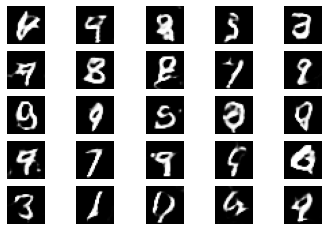

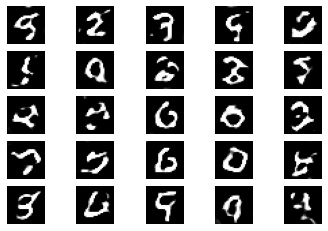

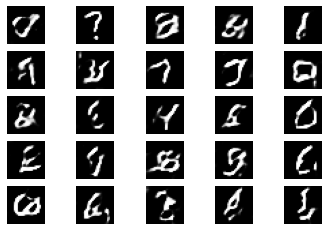

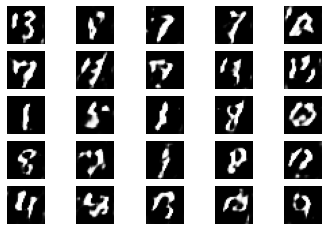

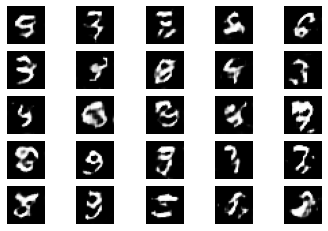

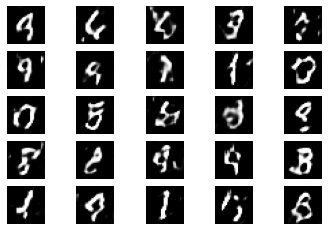

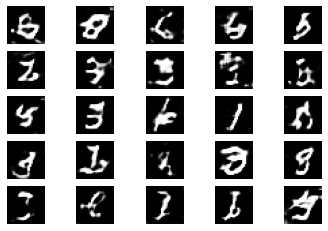

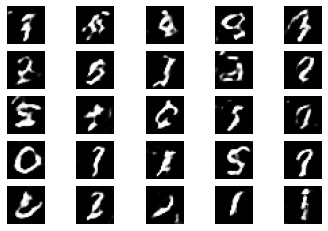

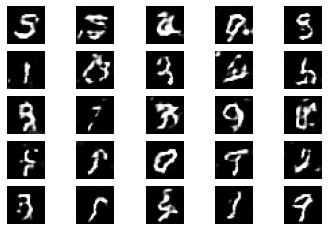

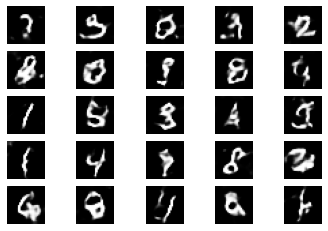

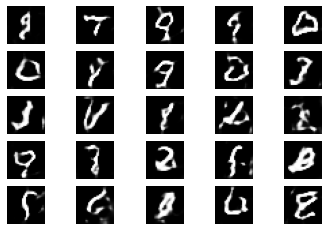

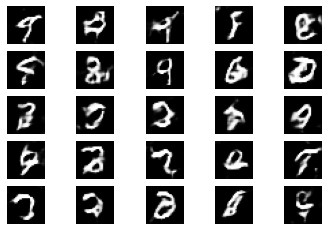

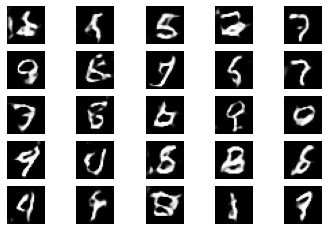

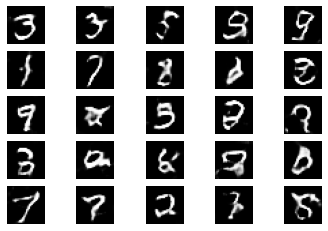

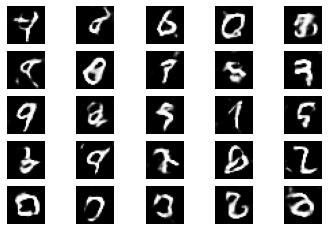

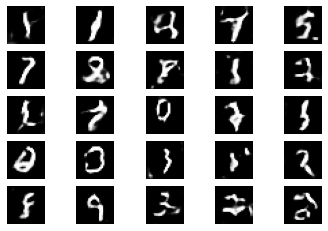

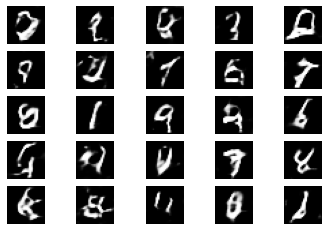

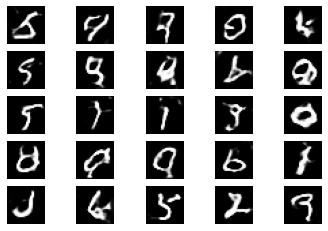

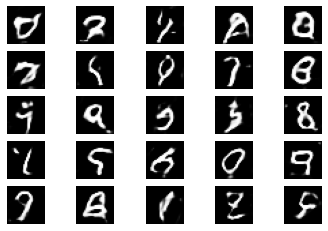

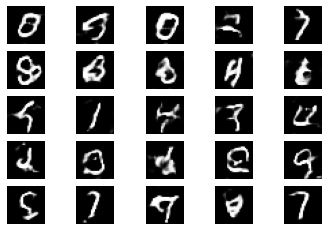

In [ ]:
def gan_train(epoch, batch_size, saving_interval):
    (x_train, _), (_, _) = mnist.load_data()
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
    x_train = (x_train - 127.5) / 127.5
    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))


    for i in range(epoch):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        
        g_loss = gan.train_on_batch(noise, true)
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        print('epoch:{} d_loss:{:.4f} g_loss:{:.4f}'.format(i, d_loss, g_loss))

        if i % saving_interval == 0:
            noise = np.random.normal(0,1,(25,100))
            gen_imgs = generator.predict(noise)
            gen_imgs = 0.5 * gen_imgs + 0.5
            fig, axs = plt.subplots(5,5)
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                    axs[j, k].axis('off')
                    count +=1
            fig.savefig('gan_images/gan_mnist_%d.png'%i)
gan_train(4000, 32, 200)

In [ ]:
import numpy as np
noise = np.random.normal(0, 1, (2, 100))
gen_imgs = generator.predict(noise)
gen_imgs = generator(noise)

# 5.Yolo

In [ ]:
import time
from absl import app, flags, logging
from absl.flags import FLAGS
import cv2
import numpy as np
import tensorflow as tf
from models import YoloV3
from utils import draw_outputs, transform_images
import matplotlib.pyplot as plt

CLASSES_PATH = 'coco.names'
WEIGHTS_PATH = './yolov3.tf'
IMAGE_SIZE = 416

yolo = YoloV3()
yolo.load_weights(WEIGHTS_PATH)
class_names = [c.strip() for c in open(CLASSES_PATH).readlines()]

#img = tf.image.decode_image(open('dog_example.jpg', 'rb').read(), channels=3)
img = tf.image.decode_image(open('dog.1503.jpg', 'rb').read(), channels=3)
plt.imshow(img)
plt.show()

input_img = tf.expand_dims(img, 0)
input_img = transform_images(input_img, IMAGE_SIZE)
boxes, scores, classes, nums = yolo(input_img)


logging.info('detections:')
for i in range(nums[0]):
    print('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                       np.array(scores[0][i]),
                                       np.array(boxes[0][i])))

prediction_img = draw_outputs(img.numpy(), (boxes, scores, classes, nums), class_names)
plt.figure(figsize=(10, 20))
plt.imshow(prediction_img)
plt.show()



In [ ]:
from models import YOLOModel/

SyntaxError: ignored

# HW day5

In [ ]:
# import gdown
# gdown.download(url='http://conlms.lge.com/dwn/ext/200/G006/2020/09/04/4092fe2e-a37e-44a3-b5af-5dc5f3cb256f.zip', output='dataset.zip', quiet=True)
# !unzip dataset.zip -d .


from tensorflow.keras.layers import Dense, Flatten
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import tensorflow as tf
import cv2
import glob

In [ ]:
base_dir = 'img/shrine_temple'
train_dir = os.path.join(base_dir,'train')
validation_dir = train_dir = os.path.join(base_dir,'validation')

train_datagen = ImageDataGenerator(   
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
    #binary => 0, 1 1차원배열
    #sparse => 정수 레이블 1차원 배열
    #categorical => one hot encoding 2차원 배열
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)


test_dir = os.path.join(base_dir,'test/unknown')


In [ ]:
conv_base = VGG16(weights='imagenet', include_top=False,
                  input_shape=(150,150,3))

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

conv_base.trainable = False

for i in range(-3, 0):
    conv_base.layers[i].trainable = True

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=2e-4),
              metrics=['accuracy'])

model.summary()

In [ ]:
result = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=10
)

In [ ]:
x_len = range(len(result.history['accuracy']))
plt.plot(x_len, result.history['accuracy'], 'bo', label='train_accuracy')
plt.plot(x_len, result.history['val_accuracy'], 'r', label='validation_accuracy')
plt.legend()
plt.title('accuracy')
plt.figure()
plt.plot(x_len, result.history['loss'], 'bo', label='train_loss')
plt.plot(x_len, result.history['val_loss'], 'r', label='validation_loss')
plt.legend()
plt.title('loss')

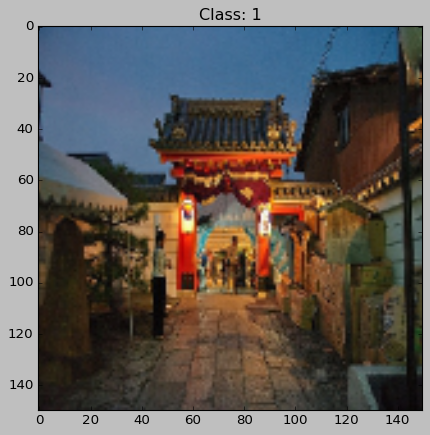

In [ ]:
test_list = glob.glob('/content/img/shrine_temple/test/unknown/*.jpg')
idx = np.random.choice(len(test_list), 1)[0]
img = plt.imread(test_list[idx])
img = cv2.resize(img, (150,150))
plt.imshow(img)
plt.title('Class: {}'.format(int(model.predict(np.expand_dims(img, 0))[0,0])))
plt.show()

# 수업자료 백업

In [ ]:
import gdown
gdown.download(url='http://conlms.lge.com/dwn/ext/200/G006/2020/09/04/75e6c793-af28-4d74-9ee7-92763f900c59.zip', output='dataset.zip', quiet=True)
!unzip dataset.zip -d .



Archive:  dataset.zip
   creating: ./day5_4/
  inflating: ./day5_4/auto_coloringModelEx.py  
  inflating: ./day5_4/ganModelEx.py  
  inflating: ./day5_4/segmentationModelEx.py  
  inflating: ./day5_4/superResolutionModelEx.py  
